In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [40]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([                   # array of transforms for training dataset
        transforms.RandomResizedCrop(224),          # randomly crops
        transforms.RandomHorizontalFlip(),          # random horizontal flips
        transforms.ToTensor(),                      # converst to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])      # normalizes pixel values
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = './hymenoptera_data/'

# stores val and train datasets in this dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                                          for x in ['train', 'val']}

# 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# chooses which device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

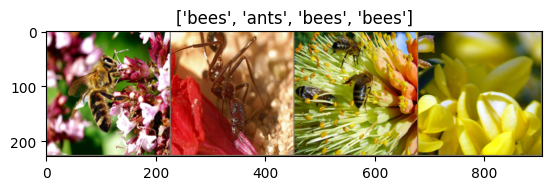

In [41]:
def imshow(inp, title=None):
    """Display image for tensor"""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])       # standard deviation
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)    # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [42]:
# Now we are going to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary dictionary to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        # saves the "best" model parameters and the models "state_dict"
        torch.save(model.state_dict(), best_model_params_path)
        # initialized the best accuracy variable
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()       # sets model to train mode
                else:
                    model.eval()        # sets model to evaluate mode

                running_loss = 0.0
                running_corrects = 0.0

                # iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameters gradient
                    optimizer.zero_grad()

                    # forward
                    # track history only if in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            
            print()
        
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load the best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [48]:
# func tp visualize model. Takes in model and number of images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()                    # evaluates model
    images_so_far = 0               # initializes number of images so far
    fig = plt.figure()

    with torch.no_grad():           # disables gradient calculation, reduces memory consumption for for computations
        for i, (inputs, labels) in enumerate(dataloaders['val']):       # 
            inputs = inputs.to(device)                                  #
            labels = labels.to(device)                                  #

            outputs = model(inputs)                                     # prediction from model
            _, preds = torch.max(outputs, 1)                            # gets the prediction from model

            for j in range(inputs.size()[0]):                           #
                images_so_far += 1                                      # adds 1 to images so far
                ax = plt.subplot(num_images//2, 2, images_so_far)       # plots the images in this case 3 in the top row (if num_images=6)
                ax.axis('off')                                          # turns axis off
                ax.set_title(f'predicted: {class_names[preds[j]]}')     # predicted title for images
                imshow(inputs.cpu().data[j])                            # shows the imahes

                if images_so_far == num_images:                         # checks if shown all images
                    model.train(mode=was_training)                      #
                    return
        model.train(mode=was_training)                                  #

In [44]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized 
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)        # decaying the learning rate helps us train the model better
                                                                                    # this is because learning can stagnate and find a minimum that would be
                                                                                    # too low for a certain learning rate to pass

In [45]:
model_conv = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5486 Acc: 0.7172
val Loss: 0.2286 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4817 Acc: 0.7869
val Loss: 0.2992 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.3901 Acc: 0.8689
val Loss: 0.3938 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.3971 Acc: 0.8443
val Loss: 0.3810 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.4764 Acc: 0.7869
val Loss: 0.3780 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.5370 Acc: 0.7869
val Loss: 0.6138 Acc: 0.7843

Epoch 6/24
----------
train Loss: 0.5290 Acc: 0.8279
val Loss: 0.2475 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3485 Acc: 0.8607
val Loss: 0.2251 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3654 Acc: 0.8279
val Loss: 0.2229 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3722 Acc: 0.8238
val Loss: 0.2214 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3108 Acc: 0.8934
val Loss: 0.2357 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2486 Acc: 0.8975
val Loss: 0.2189 Acc: 0.9216

Ep

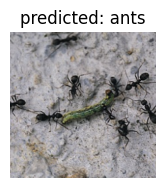

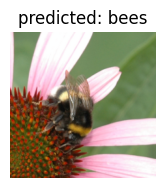

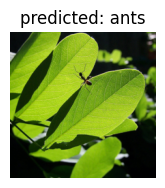

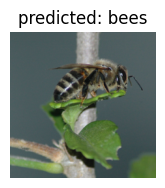

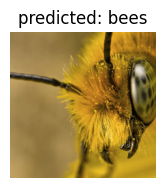

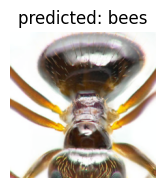

In [50]:
# shows us all the predictions
visualize_model(model_ft)

plt.ion()
plt.show()

In [55]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)                # gets prediction from model
        _, preds = torch.max(outputs, 1)    # gets prediction

        ax = plt.subplot(2, 2, 1)
        ax.axis('off')
        ax.set_title(f"Predicted: {class_names[preds[0]]}")
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

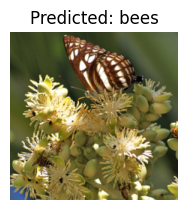

In [57]:
visualize_model_predictions(
    model_conv,
    img_path="./hymenoptera_data/val/bees/72100438_73de9f17af.jpg"
)

plt.ioff()
plt.show()